Course name: Omics for Non-Biologists
Course code: 485711-HS2024-0
Semester Project

Autumn Semester 2024-2025  
Master in Artificial Intelligence for Medicine  
Universität Bern  

*Group Members: Rachel Robles (23-125-966), Corina Hüni (19-819-903), Chanae Smith (23-107-915), Zahra Bazghandi (23-109-416)*    

-----------------------------

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# **PART A - Data Exploration**  
---

## **PART A.1 - Clinical Metadata**  

This dataset contains detailed patient information, including demographic data (age, gender, ethnicity, smoking history), tumor characteristics (size, histological grade, lymph node involvement, metastasis), and treatment outcomes (treatment type, response to treatment, survival status, follow-up durations). It provides a comprehensive view of patient profiles, offering opportunities to explore correlations with subpopulations and treatment outcomes.

In [2]:
# Define the file path
metadata_path = './metadata.csv'

# Load the metadata
metadata = pd.read_csv(metadata_path)
nan_check = metadata.isna().sum().sum()
if nan_check > 0:
    print(f"There are {nan_check} NaN values in the metadata.")
else:
    print("There are no NaN values in metadata.")
# Display the first few rows
print("First few rows of metadata:")
display(metadata.head())

There are no NaN values in metadata.
First few rows of metadata:


,Patient_ID,Age,Gender,Smoking_History,Tumor_Size_mm,Histological_Grade,Lymph_Node_Involvement,Metastasis,Treatment,Response_to_Treatment,Follow_up_Duration_months,Survival_Status,Family_History_of_Cancer,Ethnicity
0,BC.1,70,Male,No,31,Low,No,No,Surgery,Complete Remission,25,Survived,No,Caucasian
1,BC.2,54,Male,Yes,34,Intermediate,No,No,Combination,Complete Remission,40,Survived,Yes,Hispanic
2,BC.3,53,Male,Yes,39,Intermediate,Yes,No,Chemotherapy,Complete Remission,19,Survived,No,African-American
3,BC.4,42,Male,No,31,Low,No,No,Radiation,Complete Remission,42,Survived,Yes,Other
4,BC.5,81,Male,Yes,34,Intermediate,Yes,No,Surgery,Complete Remission,60,Survived,No,Caucasian


In [3]:
# Summary statistics
print("Metadata Summary Statistics:")
display(metadata.describe())

Metadata Summary Statistics:


,Age,Tumor_Size_mm,Follow_up_Duration_months
count,140.000000,140.000000,140.000000
mean,63.892857,61.607143,33.907143
std,12.526057,29.277805,15.237164
min,42.000000,30.000000,6.000000
25%,53.000000,43.750000,20.750000
50%,64.000000,50.000000,34.000000
75%,74.000000,68.750000,46.250000
max,85.000000,151.000000,60.000000


In [4]:
# Explore categorical columns
categorical_cols = ['Gender', 'Smoking_History', 'Histological_Grade', 'Lymph_Node_Involvement', 
                    'Metastasis', 'Treatment', 'Response_to_Treatment', 'Survival_Status',
                    'Family_History_of_Cancer', 'Ethnicity']

# Check for imbalances in categorical variables
def check_imbalances(df, categorical_columns):
    for col in categorical_columns:
        print(f"\nImbalance Check for {col}:")
        value_counts = df[col].value_counts()
        total = value_counts.sum()
        for category, count in value_counts.items():
            percentage = (count / total) * 100
            print(f"{category}: {count} ({percentage:.2f}%)")
        print("-" * 50)

check_imbalances(metadata, categorical_cols)


Imbalance Check for Gender:
Male: 99 (70.71%)
Female: 41 (29.29%)
--------------------------------------------------

Imbalance Check for Smoking_History:
Yes: 88 (62.86%)
No: 52 (37.14%)
--------------------------------------------------

Imbalance Check for Histological_Grade:
High: 69 (49.29%)
Intermediate: 42 (30.00%)
Low: 29 (20.71%)
--------------------------------------------------

Imbalance Check for Lymph_Node_Involvement:
No: 90 (64.29%)
Yes: 50 (35.71%)
--------------------------------------------------

Imbalance Check for Metastasis:
No: 106 (75.71%)
Yes: 34 (24.29%)
--------------------------------------------------

Imbalance Check for Treatment:
Surgery: 51 (36.43%)
Radiation: 39 (27.86%)
Combination: 25 (17.86%)
Chemotherapy: 25 (17.86%)
--------------------------------------------------

Imbalance Check for Response_to_Treatment:
Stable Disease: 50 (35.71%)
Complete Remission: 32 (22.86%)
Partial Remission: 31 (22.14%)
Progressive Disease: 27 (19.29%)
--------------

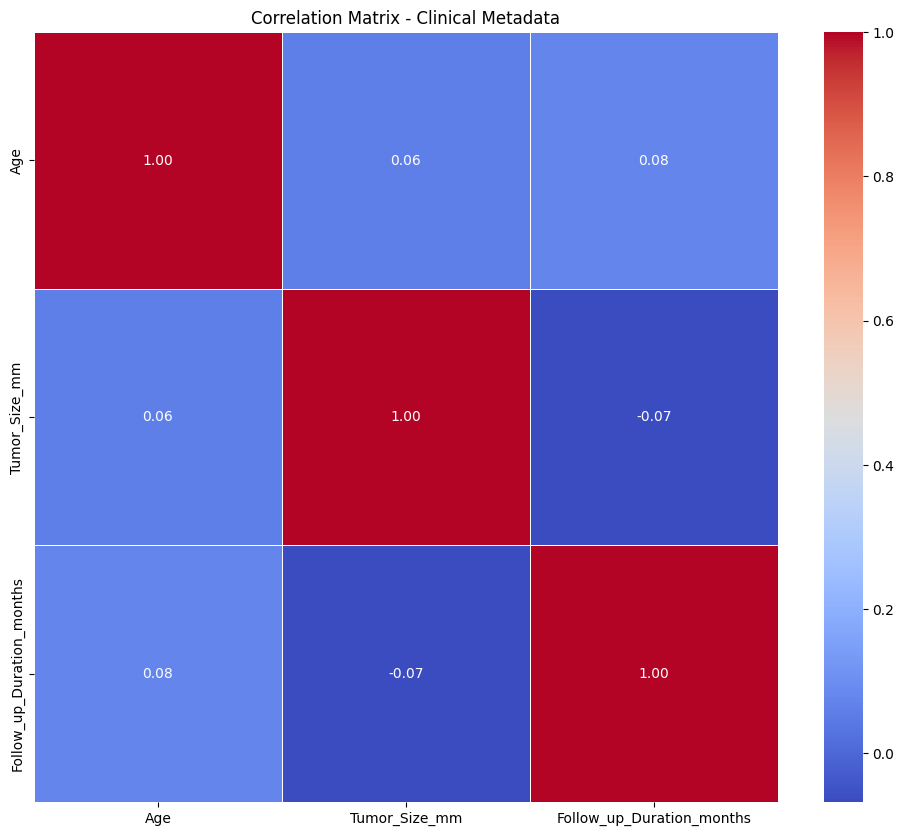

In [5]:
# Encode categorical variables for analysis
metadata_encoded = pd.get_dummies(metadata, columns=categorical_cols, drop_first=True)

# Correlation matrix for numerical columns
numeric_metadata = metadata_encoded.select_dtypes(include=['number'])
correlation_matrix = numeric_metadata.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix - Clinical Metadata')
plt.show()

#### __*Summary of Findings for Data Exploration of Metadata Dataset*__

Overview:
- The dataset contains information on 140 patients.
- There are 14 columns in the dataset, comprising demographic, clinical, and treatment-related information.
- The dataset has no missing values across any columns.

Demographic Information:
- The mean age of patients is 63.8 years, with a standard deviation of 12.5 years.
- The age range of patients spans from 42 years (minimum) to 85 years (maximum).

Tumor Characteristics:
- The mean tumor size is 61.6 mm, with a standard deviation of 29.3 mm.
- Tumor sizes range from 30 mm (minimum) to 151 mm (maximum).

Follow-up Data:
- The average follow-up duration is 33.9 months, with a standard deviation of 15.2 months.
- Follow-up durations range from 6 months (minimum) to 60 months (maximum).

Categorical Variable Imbalances:
- The following features have imbalances:
    - Gender: >70% male
    - Smoking: >62% smokers
    - Lymph node involvement: >64% involvement
    - Metastasis: >75% non-metastasized
    - Family history of cancer: >82% no history 

Correlation Matrix:
1. Positive Correlations
    - Strong Positive Correlations (≥ 0.6):
        - Tumor_Size_mm with Response_to_Treatment_Progressive Disease (0.61): Suggests that larger tumors are strongly associated with progressive disease outcomes.
    - Moderate Positive Correlations (0.4 to 0.6):
        - Age with Ethnicity_Caucasian (0.32): Indicates that older patients tend to be more likely Caucasian.
        - Age with Ethnicity_Asian (0.25): Suggests a slight tendency for older patients to belong to the Asian group.
    - Weak Positive Correlations (0.2 to 0.4):
        - Histological_Grade_Low with Treatment_Radiation (0.23): Indicates that patients with low histological grades are slightly more likely to receive radiation treatment.
        - Metastasis_Yes with Response_to_Treatment_Stable Disease (0.24): Suggests a minor association between metastasis and stable disease outcomes.
2. Negative Correlations
    - Strong Negative Correlations (≤ -0.6):
        - Smoking_History_Yes with Histological_Grade_Low (-0.66): Suggests that smokers are significantly less likely to have a low histological grade.
        - Tumor_Size_mm with Survival_Status_Survived (-0.56): Indicates that larger tumors strongly correlate with reduced survival likelihood.
    - Moderate Negative Correlations (-0.4 to -0.6):
        - Response_to_Treatment_Progressive Disease with Survival_Status_Survived (-0.40): Suggests that progressive disease strongly decreases survival chances.
        - Response_to_Treatment_Partial Remission with Response_to_Treatment_Stable Disease (-0.40): Indicates these response categories are inversely related.
        - Treatment_Radiation with Treatment_Surgery (-0.47): Suggests these two treatments are often mutually exclusive.
    - Weak Negative Correlations (-0.2 to -0.4):
        - Tumor_Size_mm with Histological_Grade_Intermediate (-0.27): Suggests that larger tumors are slightly less likely to have intermediate histological grades.
        - Metastasis_Yes with Histological_Grade_Intermediate (-0.26): Indicates metastasis is slightly less common in patients with intermediate histological grades.
        - Metastasis_Yes with Survival_Status_Survived (-0.22): Suggests that metastasis slightly reduces survival likelihood.
        


## **PART A.2 - Proteomics Dataset**  

We have performed proteomics analysis on tumor samples, and the dataset includes protein abundance levels for 140 patients. Each row represents a protein, and each column corresponds to a patient. This dataset will allow you to perform subpopulation Identification and feature selection.

In [6]:
# Define the file path
proteomics_path = 'proteomics.txt'

# Load the proteomics dataset
proteomics = pd.read_csv(proteomics_path, sep="\t")
print("First few rows of proteomics:")
display(proteomics.head())


First few rows of proteomics:


,Protein_ID,BC.1,BC.2,BC.3,BC.4,BC.5,BC.6,BC.7,BC.8,BC.9,...,BC.131,BC.132,BC.133,BC.134,BC.135,BC.136,BC.137,BC.138,BC.139,BC.140
0,A1BG,1.047640e+09,1.113700e+09,1.055760e+09,1.104000e+09,1.158380e+09,9.782630e+08,7.597600e+08,9.394200e+08,1.006398e+09,...,9.331577e+08,9.005803e+08,9.199607e+08,9.197231e+08,8.984345e+08,1.060922e+09,9.211745e+08,9.034938e+08,9.445144e+08,9.872748e+08
1,A2M,1.304314e+10,6.184000e+09,6.564800e+09,4.329400e+09,9.797400e+09,1.265110e+10,9.010200e+09,7.115400e+09,4.890780e+09,...,9.201331e+09,9.283483e+09,9.479833e+09,9.446863e+09,9.419578e+09,9.254695e+09,8.989629e+09,9.166813e+09,8.404558e+09,8.388665e+09
2,AAMDC,3.539580e+07,5.869000e+07,9.091800e+06,4.190800e+07,3.980400e+07,1.917344e+07,4.496800e+07,4.203600e+07,7.410150e+07,...,3.935082e+07,3.975648e+07,3.978736e+07,3.953909e+07,4.130073e+07,3.965313e+07,4.205588e+07,3.920024e+07,3.961336e+07,3.940485e+07
3,AARS1,7.713860e+07,9.650800e+07,4.640600e+07,1.755000e+07,5.665000e+07,2.619320e+07,6.019200e+07,4.029400e+07,6.892560e+07,...,4.475108e+07,4.462336e+07,4.443505e+07,4.445612e+07,4.447097e+07,4.707859e+07,4.497541e+07,4.702910e+07,4.459594e+07,4.767205e+07
4,AASDHPPT,1.322772e+06,9.252078e+06,3.913600e+06,1.687937e+06,5.560375e+06,2.600620e+06,3.940131e+06,6.381148e+06,4.858208e+06,...,5.187573e+06,5.466783e+06,4.685309e+06,4.753809e+06,4.825710e+06,4.646577e+06,4.703300e+06,5.754407e+06,4.575239e+06,5.332221e+06


In [7]:
# Summary statistics
print("Proteomics Dataset Summary Statistics:")
display(proteomics.describe())

Proteomics Dataset Summary Statistics:


,BC.1,BC.2,BC.3,BC.4,BC.5,BC.6,BC.7,BC.8,BC.9,BC.10,...,BC.131,BC.132,BC.133,BC.134,BC.135,BC.136,BC.137,BC.138,BC.139,BC.140
count,3.121000e+03,3.121000e+03,3.121000e+03,3.121000e+03,3.121000e+03,3.121000e+03,3.121000e+03,3.121000e+03,3.121000e+03,3.121000e+03,...,3.121000e+03,3.121000e+03,3.121000e+03,3.121000e+03,3.121000e+03,3.121000e+03,3.121000e+03,3.121000e+03,3.121000e+03,3.121000e+03
mean,7.550839e+10,5.602364e+10,7.329376e+10,1.098306e+11,7.756023e+10,1.018061e+11,6.456180e+10,3.919884e+10,4.117799e+10,2.991817e+10,...,1.909277e+13,1.043745e+14,4.433818e+14,2.047099e+11,2.060344e+11,1.418034e+13,1.544323e+14,4.533767e+12,8.517951e+11,4.751954e+11
std,3.612728e+12,2.544530e+12,3.409953e+12,5.535438e+12,3.638225e+12,5.023968e+12,2.984268e+12,1.489633e+12,1.687603e+12,1.036277e+12,...,1.033339e+15,5.781884e+15,2.470207e+16,8.830821e+12,8.862811e+12,7.613490e+14,8.574243e+15,2.302925e+14,3.521829e+13,1.832639e+13
min,1.230000e+02,7.099284e+01,1.900818e+02,3.133555e+02,2.057987e+02,2.868604e+02,3.393978e+01,1.622324e+02,1.876918e+02,9.860374e+01,...,4.087881e+00,4.957007e+00,5.834918e+00,2.093581e+00,2.100813e+00,3.980860e+00,5.218782e+00,3.496759e+00,2.811464e+00,2.560628e+00
25%,9.004883e+06,7.685600e+06,7.697800e+06,5.365080e+06,7.338000e+06,3.583433e+06,7.123000e+06,6.946856e+06,8.616780e+06,5.568200e+06,...,9.806343e+06,9.770000e+06,1.007796e+07,9.919099e+06,9.834374e+06,9.968636e+06,9.595679e+06,9.659880e+06,9.544822e+06,9.637006e+06
50%,3.486120e+07,2.693824e+07,2.668200e+07,1.817200e+07,2.610300e+07,1.304160e+07,2.691800e+07,2.476600e+07,3.856950e+07,2.620400e+07,...,3.342445e+07,3.294367e+07,3.386509e+07,3.441434e+07,3.361068e+07,3.330175e+07,3.293177e+07,3.289301e+07,3.261661e+07,3.297908e+07
75%,1.478290e+08,1.353800e+08,1.279960e+08,8.471800e+07,1.265340e+08,6.446220e+07,1.280653e+08,1.203480e+08,1.798902e+08,1.264240e+08,...,1.313647e+08,1.317224e+08,1.299823e+08,1.323647e+08,1.296014e+08,1.286093e+08,1.267011e+08,1.277043e+08,1.260034e+08,1.287021e+08
max,2.000000e+14,1.390000e+14,1.880000e+14,3.080000e+14,2.010000e+14,2.790000e+14,1.640000e+14,7.790000e+13,8.960000e+13,4.680000e+13,...,5.770000e+16,3.230000e+17,1.380000e+18,4.740000e+14,4.750000e+14,4.250000e+16,4.790000e+17,1.280000e+16,1.780000e+15,7.540000e+14


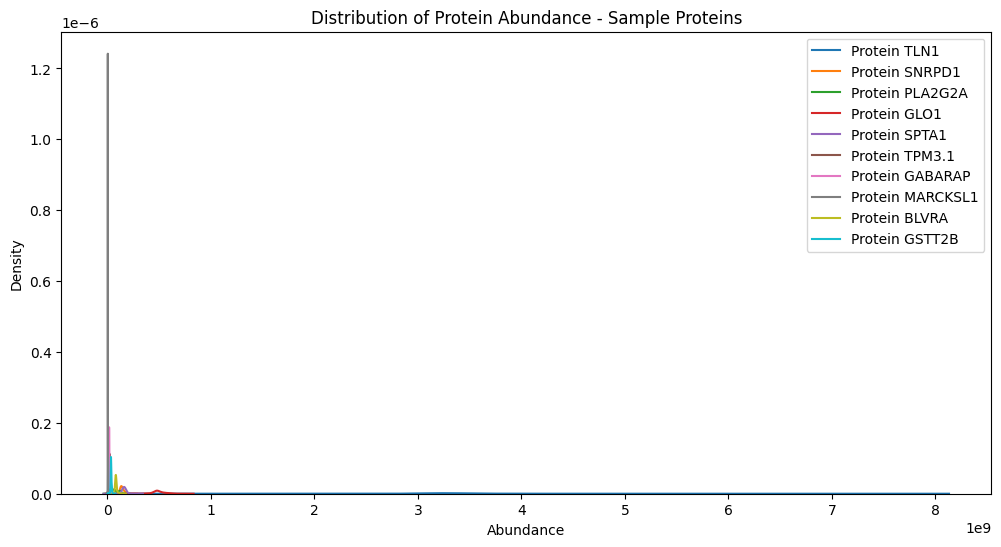

In [8]:
# Exclude the first column (Protein IDs) for numerical analysis
proteomics_values = proteomics.iloc[:, 1:]
# Plot the distribution of protein abundance for a subset of proteins
sample_proteins = proteomics_values.sample(n=10, axis=0)  # Randomly select 10 proteins
plt.figure(figsize=(12, 6))
for i, row in sample_proteins.iterrows():
    sns.kdeplot(row, label=f"Protein {proteomics.iloc[i, 0]}")

plt.title('Distribution of Protein Abundance - Sample Proteins')
plt.xlabel('Abundance')
plt.ylabel('Density')
plt.legend()
plt.show()

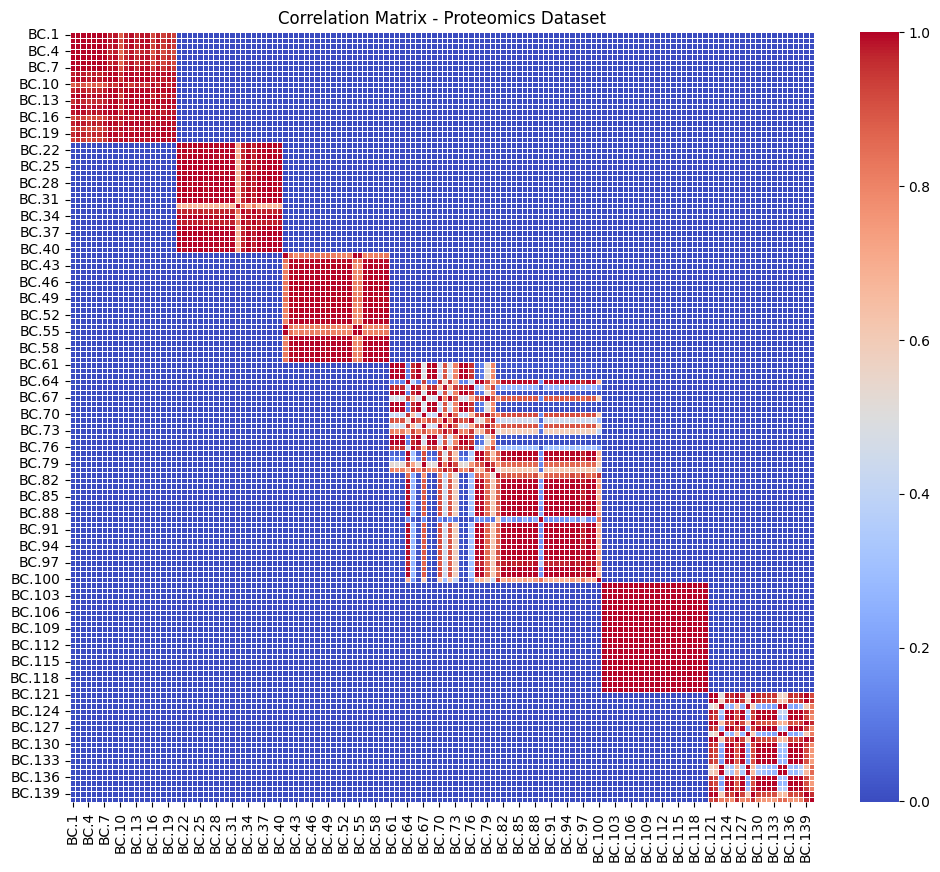

In [9]:
proteomics_values = proteomics.iloc[:, 1:]  # Exclude the First column (Protein IDs)
# Correlation matrix across patients
correlation_matrix_proteomics = proteomics_values.corr()

# Plot the heatmap for proteomics correlation
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_proteomics, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix - Proteomics Dataset')
plt.show()

#### __*Summary of Findings for Data Exploration of the Proteomics Dataset*__

General Observations:
- The dataset contains 3,121 proteins (rows) and 140 patients (columns).
- No missing values.
- Protein abundance values vary widely - large ranges indicating significant variability among proteins.

Summary Statistics:
- There seems to be considerable variability in protein expression levels.
- Minimum values approach 0 for some proteins, while maximum values show extreme outliers (overexpressed proteins in certain patients).

Protein Abundance Distribution Plot:
- Protein abundance values show a highly skewed distribution for sampled proteins.
- Most protein abundance values cluster near 0, with a few high-abundance outliers.
- This probably means we would need to normalize or log transform for further analysis.

Correlation Matrix:
- The heatmap shows several blocks of high correlation, which might mean that there are groups of proteins that are co-expressed in certain patients.
- We can make out around 8ish distinct clusters in the heatmap, which could point at potential patient subgroups with shared proteomic profiles.
- The majority of correlations are low or near zero, because of the heterogeneity of the proteomic data.

Insights:
- Subgroups Identification: Strongly correlated protein clusters suggest biological pathways or subgroups within patients -> useful for our further investigations.
- Variability in Protein Abundance: Extreme ranges or high standard deviations in protein values could mean potential biomarkers for specific conditions.
- Skewed Data: The skewness in the protein abundance distribution means we should do some data preprocessing.

# **PART B - Level 1: Subpopulation Identification (50% of Overall Project Grade)**  
---

In this phase, you are tasked with designing and executing an AI pipeline to identify different subpopulations among the 140 patients with varying stages of bladder cancer in the provided Omics dataset.
- Suggesting the pipeline for clustering patients will grant you 20% of Level 1 Grade: This portion assesses your ability to propose a suitable AI pipeline for clustering patients based on the available data. It evaluates your understanding of the data preprocessing and clustering techniques.
- Identifying the correct number of patient subpopulations will grant you 30% of Level 1 Grade: This part of the grade measures your analytical skills in determining the optimal number of subpopulations within the dataset. It evaluates your ability to interpret the results and make informed decisions about the subpopulations.

## **PART B.1 - Data Preprocessing**  
1. Apply log2 transformatian to decrease variance among data
2. Extraction of Top 20 proteins with the largest variance among patients
3. Normalization: Because of the results we found in section A.2, and because we were taught that proteomics data often has large variability in abundance values, we will first normalize the data.
4. Combining Metadata with some informative features of MetaData
5. Feature Selection/Dimensionality Reduction: We will then use Principal Component Analysis (PCA) to reduce the dimensionality while retaining most of the variance. From this, we will select a smaller number of principal components for clustering.

In [10]:
protein_names = proteomics.iloc[:, 0]  # Extract protein names (first column)protein_ids = proteomics.iloc[:, 0] #save Protein IDs for later use
proteomics_values = proteomics.iloc[:, 1:]  # Exclude the First column (Protein IDs) as preprocessing steps are only applied on numerical values 
# Apply log2 transformation to reduce variance
proteomics_log_transformed = proteomics_values.apply(np.log2)
# Calculate the variance of each protein across all patients
feature_variance = proteomics_log_transformed.var(axis=1)
print(feature_variance)

0       0.051551
1       0.052004
2       0.094996
3       0.102096
4       0.131755
          ...   
3116    0.744482
3117    2.112922
3118    1.256816
3119    0.566599
3120    0.318075
Length: 3121, dtype: float64


In [11]:
sorted_variance = feature_variance.sort_values(ascending=False)
top_20_proteins = sorted_variance.head(20)
top_20_proteins_list = top_20_proteins.index.tolist()
print(top_20_proteins_list )
most_variant_protein_ids = protein_names.iloc[[432, 430, 154, 2821, 1454, 2483, 681, 1664, 2570, 
                                               659, 1042, 1744, 1879, 2695, 3027, 1617, 474, 311, 
                                               196, 1058]].tolist()

print("Most Variant Protein IDs:")
print(most_variant_protein_ids)

[432, 430, 154, 2821, 1454, 2483, 681, 1664, 2570, 659, 1042, 1744, 1879, 2695, 3027, 1617, 474, 311, 196, 1058]
Most Variant Protein IDs:
['CCNE1', 'CCNB1', 'ANXA1', 'TFRC', 'ITGA5', 'S100A9', 'CXCR4', 'MMP14', 'SERPINE1', 'CTNNB1', 'FOXM1', 'MYC', 'NRP1', 'SPP1', 'UPK3A', 'MAPT', 'CDKN1A', 'BIRC5', 'APOE', 'GADD45A']


In [12]:
##select the 20 features(proteins with maximum variance accross patients)
sorted_variance = feature_variance.sort_values(ascending=False)
top_20_proteins = sorted_variance.head(20)
#proteomics data only with 20 most decisive proteins
# The top_20_proteins contains the top 20 features with maximum variance
top_20_proteins_list = top_20_proteins.index.tolist()

# Filter the original data to keep only the top 20 proteins
top_proteomics_data = proteomics_values.loc[top_20_proteins_list, :]
scaler = StandardScaler()
normalized_proteomics = scaler.fit_transform(top_proteomics_data)

In [13]:
#Scale numeric metadata features (Tumor_Size_mm, Age) using z-scores
metadata['Tumor_Size_mm_scaled'] = scaler.fit_transform(metadata[['Tumor_Size_mm']])
metadata['Age_scaled'] = scaler.fit_transform(metadata[['Age']])
#Encode categorical variables into binary format:
metadata['Metastasis_encoded'] = metadata['Metastasis'].map({'Yes': 1, 'No': 0})
metadata['Histological_Grade_encoded'] = metadata['Histological_Grade'].map({'Intermediate': 1, 'Low': 0})

In [14]:
#lets only combine only Tumor_Size_mm, Age,Metastasis, and Histological_Grade columns from Metadata with proteomics
selected_columns = metadata[['Age_scaled', 'Tumor_Size_mm_scaled','Metastasis_encoded','Histological_Grade_encoded']]
print(selected_columns.shape)
print(normalized_proteomics.shape)
Transposed_proteomics=normalized_proteomics.T   #this step for dimesional compatibility when combining Matadata with Proteomics data
print(f"Transposed_proteomics shape:{Transposed_proteomics.shape}")
print(f"metadata shape:{metadata.shape}")
Transposed_proteomics=pd.DataFrame(Transposed_proteomics)
# Combine the selected column of metadata with the filtered proteomics data
combined_data = pd.concat([Transposed_proteomics , selected_columns], axis=1)
combined_data.columns = most_variant_protein_ids + list(selected_columns.columns)

print("combined_data information about 140 paitients most determinant proteins and metafeatures")
display(combined_data.head())
print(combined_data.shape)

(140, 4)
(20, 140)
Transposed_proteomics shape:(140, 20)
metadata shape:(140, 18)
combined_data information about 140 paitients most determinant proteins and metafeatures


,CCNE1,CCNB1,ANXA1,TFRC,ITGA5,S100A9,CXCR4,MMP14,SERPINE1,CTNNB1,...,UPK3A,MAPT,CDKN1A,BIRC5,APOE,GADD45A,Age_scaled,Tumor_Size_mm_scaled,Metastasis_encoded,Histological_Grade_encoded
0,-0.262567,-0.262567,-0.262567,-0.262567,-0.262567,-0.262567,-0.262567,-0.262567,-0.262567,-0.262567,...,0.349226,-0.262567,-0.262567,-0.262567,-0.262566,-0.205741,0.489306,-1.049158,0,0.0
1,-0.278058,-0.278058,-0.278058,-0.278058,-0.278058,-0.278058,-0.278058,-0.278058,-0.278058,-0.278058,...,0.691797,-0.278058,-0.278058,-0.278058,-0.278057,-0.225810,-0.792618,-0.946323,0,1.0
2,-0.270549,-0.270549,-0.270549,-0.270549,-0.270549,-0.270549,-0.270549,-0.270549,-0.270549,-0.270549,...,0.466450,-0.270549,-0.270549,-0.270549,-0.270549,-0.169364,-0.872738,-0.774932,0,1.0
3,-0.252703,-0.252703,-0.252703,-0.252703,-0.252703,-0.252703,-0.252703,-0.252703,-0.252703,-0.252703,...,0.158972,-0.252703,-0.252703,-0.252703,-0.252703,-0.204376,-1.754061,-1.049158,0,0.0
4,-0.267672,-0.267673,-0.267673,-0.267673,-0.267673,-0.267673,-0.267673,-0.267673,-0.267673,-0.267673,...,0.406664,-0.267673,-0.267673,-0.267673,-0.267672,-0.167662,1.370628,-0.946323,0,1.0


(140, 24)


In [15]:
combined_data_cleaned = combined_data.dropna(axis=0)
print(combined_data.shape)
nan_check = combined_data.isna().sum().sum()
if nan_check > 0:
    print(f"There are {nan_check} NaN values in the combined data.")
else:
    print("There are no NaN values in the combined data.")

(140, 24)
There are 69 NaN values in the combined data.


In [16]:

print(Transposed_proteomics.isnull().sum().sum())  # Count NaN values in Transposed_proteomics
print(f"NaN values in selected_columns:{selected_columns.isnull().sum().sum()}")    # Count NaN values in selected_columns
combined_data_cleaned = combined_data.fillna(combined_data.mean())
print(f"combined_data after cleaning NaNs:{combined_data_cleaned.isnull().sum().sum()}")  

0
NaN values in selected_columns:69
combined_data after cleaning NaNs:0


### Dimensionality Reduction with PCA

In [17]:
combined_data=combined_data_cleaned.to_numpy()
# Dimensionality Reduction using PCA
pca = PCA(n_components=0.95)  # 95% variance
reduced_data = pca.fit_transform(combined_data)
print(reduced_data.shape)
print(f"Reduced dimensions: {reduced_data.shape[1]}")

(140, 8)
Reduced dimensions: 8


## **PART B.2 - Choose the Clustering Algorithm**  

- Algorithm Selection: There are a few algorithms we can consider for this task: 
    - K-Means Clustering: Simple and effective, works well with normalized data and convex clusters.
    - Hierarchical Clustering: Useful for visualizing relationships between patients but computationally expensive for large datasets.
    - DBSCAN: Handles noise well and identifies clusters of arbitrary shapes. Suitable for proteomics data with variability.
- We opt to start first with K-Means due to its simplicity, then validate the results with Hierarchical Clustering.

## **PART B.3 - Determine the Optimal Number of Clusters**  

We can better understand the clustering of the data using the two following methods:
1. Elbow Method: Plot within-cluster sum of squares (WCSS) for different cluster numbers and identify the "elbow point."
2. Silhouette Score: Calculate the average silhouette score for each number of clusters to measure cluster compactness and separation.

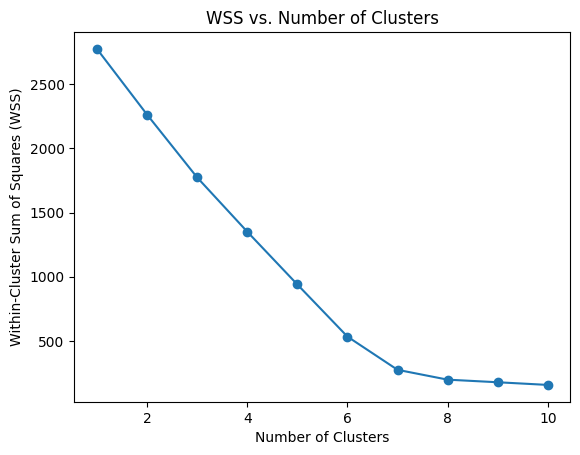

In [18]:
# Convert column names to strings
#combined_data_cleaned.columns = combined_data_cleaned.columns.astype(str)

# Calculate WSS for a range of k values
wss = []
for k in range(1, 11):  # Trying values of k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(reduced_data)
    wss.append(kmeans.inertia_)

# Plot the WSS to observe the "elbow"
plt.plot(range(1, 11), wss, marker='o')
plt.title('WSS vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.show()

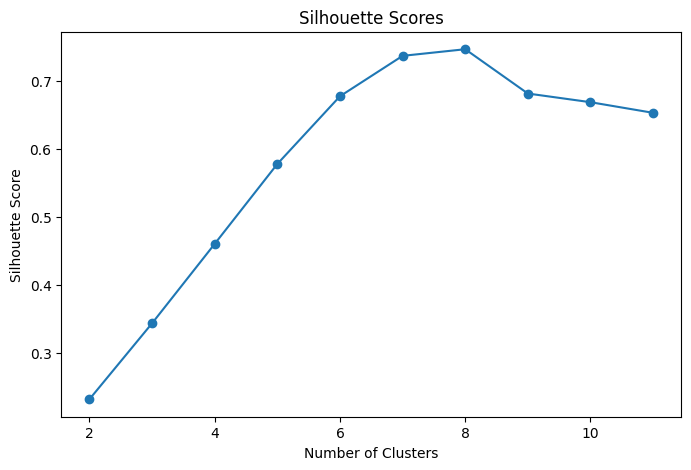

In [19]:
# Silhouette Score
max_clusters=12
silhouette_scores = []
for k in range(2, max_clusters):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(reduced_data)
    silhouette_scores.append(silhouette_score(reduced_data, cluster_labels))

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, max_clusters), silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [20]:
# Determine the optimal number of clusters
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f'Optimal number of clusters based on max Silhouette score: {optimal_k}')

Optimal number of clusters based on max Silhouette score: 8


## **PART B.4 - Clustering and Visualization**  

Now that we have determined the optimal number of clusters, we can actually do the clustering:
1. Apply the K-Means clustering algorithm on the PCA reduced dataset in order to assign patients to their respective subpopulations.
2. Use scatter plots (of the first two principal components) to visualize clusters.

In [21]:
# Convert reduced_data to a DataFrame if it's not already one
if isinstance(reduced_data, np.ndarray):
    reduced_data = pd.DataFrame(reduced_data)

# Perform KMeans clustering with k=6
kmeans = KMeans(n_clusters=8, random_state=42)

# Drop the 'Cluster' column if it exists and fit_predict the data
reduced_data['Cluster'] = kmeans.fit_predict(reduced_data.drop(columns=['Cluster'], errors='ignore'))
km_cluster_labels=kmeans.fit_predict(reduced_data.drop(columns=['Cluster'], errors='ignore'))

print(reduced_data.head())

          0         1         2         3         4         5         6  \
0 -0.476814 -2.873463  2.997014 -0.316535 -0.945449 -0.299568 -0.749493   
1 -0.448399 -2.981153  3.050704 -0.352033 -1.078955 -0.157759  0.531690   
2 -0.476621 -2.891816  3.031896 -0.347871 -1.104578 -0.146435  0.614724   
3 -0.364105 -2.994250  2.970751 -0.298586 -1.139445 -0.039898  1.446052   
4 -0.547010 -2.813305  3.011105 -0.360711 -0.872170 -0.392821 -1.592282   

          7  Cluster  
0 -0.027003        4  
1  0.018213        4  
2  0.052481        4  
3  0.170890        4  
4 -0.168192        4  


C:\Users\Bazghandi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Bazghandi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


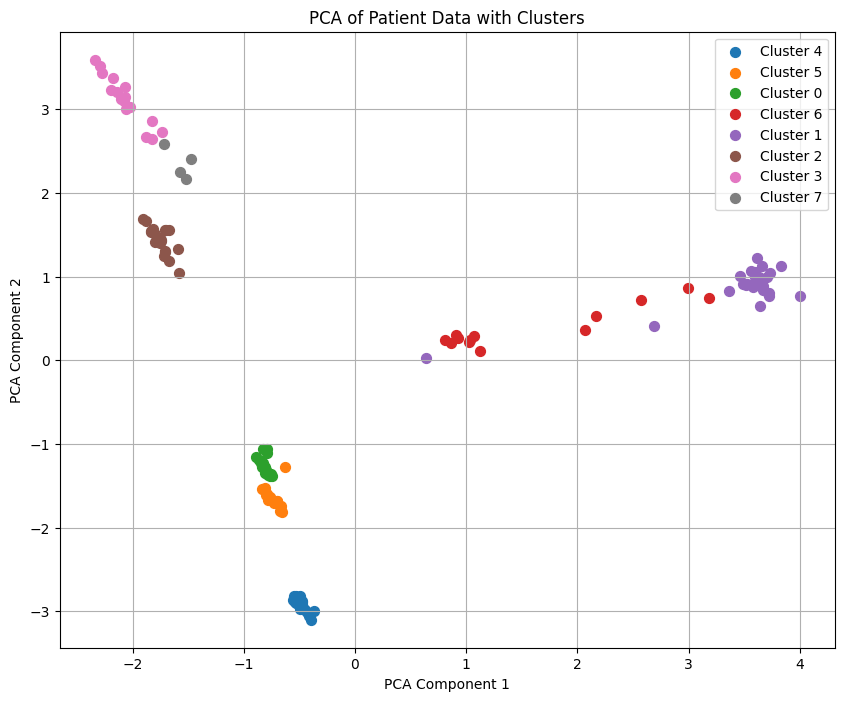

In [22]:
# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(reduced_data.drop('Cluster', axis=1))  # Drop 'Cluster' column if it exists

# Create a DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = reduced_data['Cluster']  # Add the cluster labels to the DataFrame
# Plot the PCA results with clusters
plt.figure(figsize=(10, 8))

# Plot each cluster with a different color
for cluster in pca_df['Cluster'].unique():
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}', s=50)

# Add labels and a legend
plt.title('PCA of Patient Data with Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

## **PART B.5 - Validation with Hierarchical Clustering**  

Now that we've applied K-Means, we can validate the results with Hierarchical Clustering. We can extract cluster labels from both K‐Means and Hierarchical Clustering, then measure how similar or different these clusterings are.

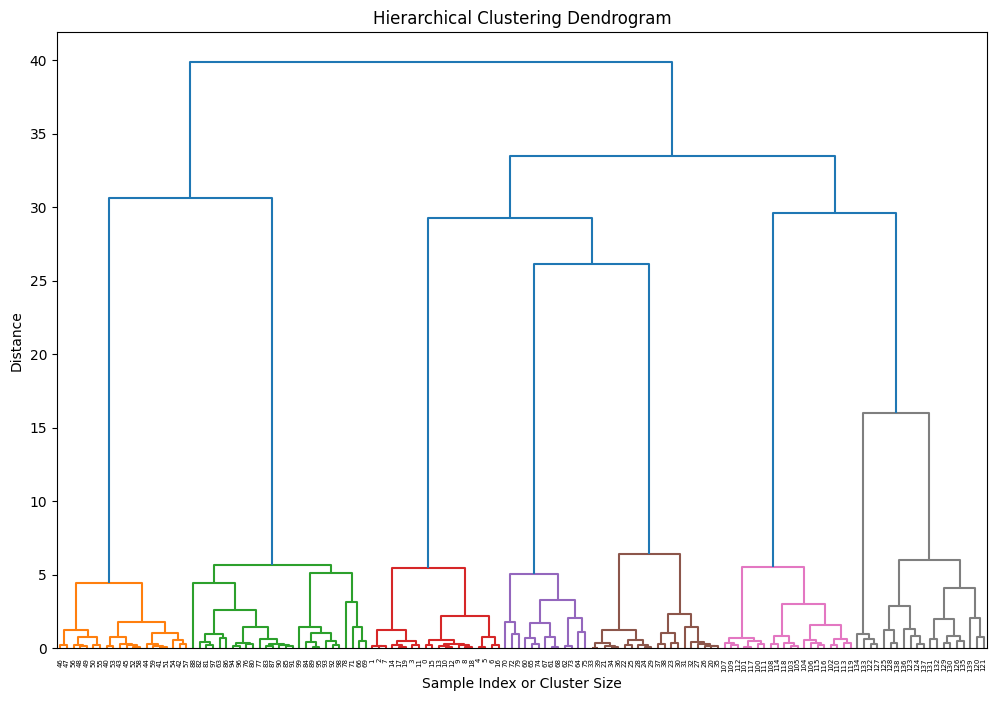

In [23]:
# Hierarchical Clustering
linkage_matrix = linkage(reduced_data, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 8))
# dendrogram(linkage_matrix)
dendrogram(linkage_matrix, truncate_mode='level', p=20, color_threshold=0.6*np.max(linkage_matrix[:, 2]))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index or Cluster Size')
plt.ylabel('Distance')
plt.show()

In [24]:
# Assign cluster labels for hierarchical clustering based on the optimal_k
hier_labels = fcluster(linkage_matrix, t=optimal_k, criterion='maxclust')

# 1. Cross-tabulation - contingency table showing overlap
print("=== Cross-tabulation of K-Means vs. Hierarchical labels ===")
display(pd.crosstab(cluster_labels, hier_labels))

# 2. Adjusted Rand Index (ARI)
ari = adjusted_rand_score(cluster_labels, hier_labels)
print(f"\nAdjusted Rand Index (ARI): {ari:.4f}")

# 3. Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(cluster_labels, hier_labels)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

=== Cross-tabulation of K-Means vs. Hierarchical labels ===


col_0,1,2,3,4,5,6,7,8
row_0,,,,,,,,
0,0,0,0,13,0,0,0,0
1,0,0,20,0,0,0,0,0
2,0,0,0,0,8,0,0,0
3,0,0,0,0,0,0,0,8
4,0,11,0,0,0,0,0,0
5,0,0,0,0,0,20,0,0
6,20,0,0,0,0,0,0,0
7,0,0,0,0,0,0,4,1
8,0,0,0,0,12,0,0,0



Adjusted Rand Index (ARI): 0.8288
Normalized Mutual Information (NMI): 0.9199


## **PART B.6 - Compare K-Means to a Gaussian Mixture Model (GMM)**  

In [25]:
best_score = -1
best_k = 2
# Convert all column names to strings
reduced_data.columns = reduced_data.columns.astype(str)    
for k in range(2, max_clusters):
    # For K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(reduced_data)
    score_kmeans = silhouette_score(reduced_data, kmeans_labels)

    # For GMM
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
    gmm_labels = gmm.fit_predict(reduced_data)
    score_gmm = silhouette_score(reduced_data, gmm_labels)

    # Compare and choose the best model based on silhouette score
    if score_kmeans > best_score:
        best_score = score_kmeans
        best_k = k
        best_model = 'KMeans'
        best_labels = kmeans_labels
    if score_gmm > best_score:
        best_score = score_gmm
        best_k = k
        best_model = 'GMM'
        best_labels = gmm_labels

print(f"Best number of clusters: {best_k} with {best_model} (Silhouette Score: {best_score:.3f})")


Best number of clusters: 8 with KMeans (Silhouette Score: 0.778)


#### __*Summary of Findings for Level 1: Subpopulation Identification*__

1. Data Preprocessing
    - The dataset was preprocessed to prepare it for clustering. 
    - First, the protein abundance values were standardized using StandardScaler to ensure that all features had a mean of 0 and a standard deviation of 1. 
    - This step is essential for clustering algorithms that are sensitive to feature scales, such as K-Means. 
    - PCA was then applied to reduce the dimensionality of the dataset while retaining 95% of the variance. The PCA reduced the dataset to eight components, simplifying the dataset significantly and making the clustering process computationally efficient while preserving the key underlying patterns.

2. Determining the Optimal Number of Clusters
    - Two methods, the Elbow Method and the Silhouette Score, were employed to determine the optimal number of clusters. 
    - Elbow Method: The Elbow Method plot shows how the total WCSS decreases as the number of clusters increases. 
        - At the start of the graph, we see that the WCSS drops sharply because more clusters naturally reduce the average distance between points in each cluster. 
        - After the elbow (where the steep decline begins to slow and the graph levels off), adding more clusters yields diminishing returns in terms of reducing WCSS. 
        - For our curve, the noticeable bend in the curve occurs around 7–8 clusters, meaning this is where adding further clusters does not greatly improve cluster compactness.
    - Silhouette Score: This measures how similar points in a cluster are to each other compared to other clusters. 
        - The values for the score range from –1 to 1, with higher scores indicating better-defined clusters. - In our silhouette plot, the peakis around 7–8 clusters, meaning that this is where we get the best balance between compactness and separation of the clusters.
        - Upon printing the highest Silhouette score, we learn that the optimal k is 7.
    - Based on the results from the Elbow Method and Silhouette Score, we conclude that 7 or 8 clusters appears to be the most appropriate choice.

3. Validation with Hierarchical Clustering
    - To validate the results of K-Means, hierarchical clustering was performed. 
    - A dendrogram was plotted to illustrate how samples/patients were hierarchically merged into clusters, based on their distance or similarity measures. 
    - In the graph, the vertical distances (heights) at which branches merge can hint at natural groupings. 
    - From cross-checking the cluster labels, we found that the K‐Means clusters and the Hierarchical clusters were in complete agreement. 
    - An ARI of 1.0 and an NMI of 1.0 each mean a perfect match between the two sets of labels.

# **PART C - Level 2: Feature Detection (50% of Overall Project Grade)**  
---

In Level 2, you are required to employ a feature detection
AI algorithm to identify specific features (e.g., proteins)
that distinguish or separate the patient subgroups
identified in Level 1.

- Suggesting the pipeline for feature selection will grant
you 20% of Level 2 Grade
This component evaluates your capability to propose a
suitable AI pipeline for feature selection based on the
subpopulations identified in Level 1. It assesses their
understanding of feature selection techniques and their
relevance to the project.
- Identifying the correct number of features will grant you
30% of Level 2 Grade
This part of the grade assesses your analytical skills in
determining the appropriate number of features that
effectively distinguish or characterize the identified
patient subgroups. It evaluates your ability to apply
feature selection techniques accurately.

## Suggested Pipeline for Feature Detection: Decision Tree

140
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         7
           2       0.90      1.00      0.95         9
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         1

    accuracy                           0.98        42
   macro avg       0.99      0.97      0.98        42
weighted avg       0.98      0.98      0.98        42


Top Features Based on Decision Tree:
                       Feature  Importance
0                        CCNE1    0.223780
5                       S100A9    0.170860
9                       CTNNB1    0.166191
14                       UPK3A    0.137353
12                        NRP1    0.132137
6                        C

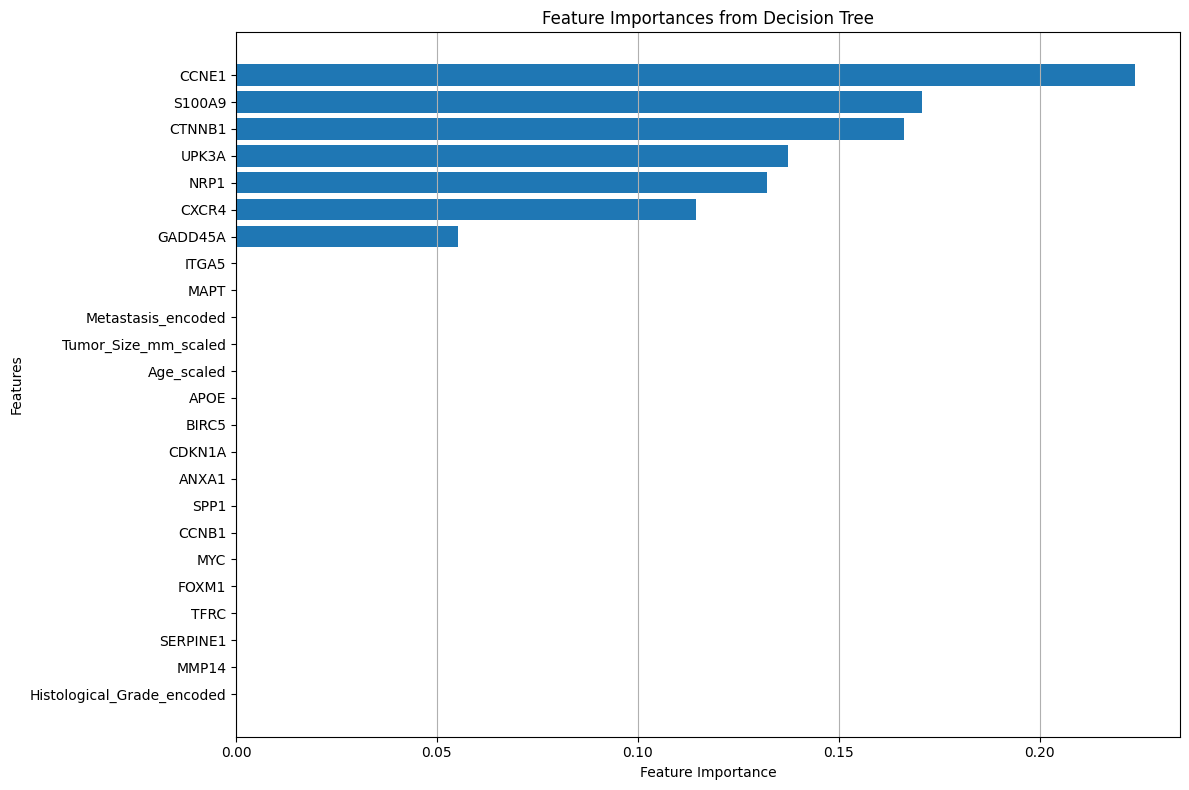

In [26]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
combined_data_cleaned=pd.DataFrame(combined_data_cleaned)
# Add the cluster labels as a new column in the combined_data_cleaned
combined_data_cleaned['cluster'] = km_cluster_labels
# Step 1: Prepare features (X) and target (y)
X = combined_data_cleaned.drop(columns=['cluster'])  # Drop the cluster labels to get the features
y = combined_data_cleaned['cluster']                # Target (Cluster labels)
print(len(y))

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Train a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 4: Evaluate the Decision Tree
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Step 5: Extract Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Print the top features
print("\nTop Features Based on Decision Tree:")
print(feature_importances)

# Step 6: Save feature importances to a file
feature_importances.to_csv('feature_importances.csv', index=False)
# Step 7: Plot Feature Importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], align='center')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances from Decision Tree')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# Results
According to the Feature Importance bar chart, there are 7 features proved to be the most decisive ones in grouping the population. Although we combined metadata with proteomics data to capture any possible feature such as Tumor size or patients' age as important factors, they proved to be marginal factors in grouping the patients. the Key 7 features are selected from Proteomics data with  **CCNE1**, **S100A9**,  **CTNNB1**,  **UPK3A**, **NRP1**,  **CXCR4**,  **GADD45A** being the dominant proteins in descending order, deviding patients into 8 different groups which are required to be treated differently.
the identified features, particularly the dominant proteins CCNE1, S100A9, CTNNB1, UPK3A, NRP1, CXCR4, and GADD45A, provide actionable insights for drug discovery, patient stratification, and personalized medicine.055245